In [6]:
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Number of data points
#S = 500

# time inteval

delta = 1/12

#n = int(S/delta)
n = 1000

# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))


sim = 0

1001


In [8]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A100-PCIE-40GB


In [9]:
kappa_range = [0.6, 3.5]
beta_range = [0.5, 2]
sigma2_range = [0.1, 0.5]

lambda_range = [0.01, 1]
mu_range = [0.1,1.5]

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from DNN_module import Net
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Default : cuda
torch.set_default_device('cuda')

# Define the batch size
BATCH_SIZE = 64

# Number of Epochs
N_EPOCHS = 350
    
# Number of Simulations
sims = 10

# Number of observation
#nums = [500, 1000, 3000]

for sim in range(0, 4):
        # Data import
        sim_path = "../../../depot_hyun/hyun/SQRJ/SQRJ_sim" + str(sim) + "_" + str(n)+ ".pt"
        [X_raw, output] = torch.load(sim_path)
        X_raw = X_raw.to("cpu")
        
        
        c_tmp = torch.quantile(X_raw, torch.tensor([.0001,.9999], device = "cpu"), 0)
        a = torch.reshape(c_tmp[0], (1, c_tmp.size()[1]))
        b = torch.reshape(c_tmp[1], (1, c_tmp.size()[1]))
        
        scale_path = "SQRJ_sim/SQRJ_scale/SQRJ_scale" + str(sim) + "_" + str(n)+ ".pt"
        torch.save([a,b], scale_path)

        X = torch.clone((X_raw - a) / (b - a))
        torch.set_default_device(dev)
        X = X.to(dev)
        output = output.to(dev)
        
        L = X.size()[0]
        Lval = 40000
        Ltest = 10000
        

        X_train = X[range(0,L-Lval-Ltest),:]
        y_train = output[range(0,L-Lval-Ltest),:]

        X_val = X[range(L-Lval-Ltest,L-Ltest),:]
        y_val = output[range(L-Lval-Ltest,L-Ltest),:]

        X_test = X[range(L-Ltest,L),:]
        y_test = output[range(L-Ltest,L),:]

        print(X_train.size(), X_val.size(),X_test.size())
        
        
        # Use torch.utils.data to create a DataLoader that will take care of creating batches
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))

        # Get the dataset size for printing (it is equal to N_SAMPLES)
        dataset_size = len(dataloader.dataset)
        
        # Define the input and output dimensions
        D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

        # Create an instance of the Net class with specified dimensions
        torch.manual_seed(2725)
        net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)

        # Model name
        model_save_name = 'SQRJ_nets/SQRJ_' + str(sim) + "_" + str(n)+ ".pt"
        path = F"./{model_save_name}"

        # The nn package also contains definitions of popular loss functions; in this case we will use Mean Squared Error (MSE) as our loss function.
        def weighted_mse_loss(input, target, weight):
            return (weight * (input - target) ** 2).sum()
    
        out_range = [torch.quantile(y_train,.01, 0).detach().cpu().numpy(), 
                     torch.quantile(y_train,.99, 0).detach().cpu().numpy()]
        weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)

        learning_rate = 1e-5
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

        train_error_plt = []
        val_error_plt = []

        torch.manual_seed(2000 + sim)

        # Loop over epochs
        file = open("log/SQRJ_sim.txt","a")
        file.write(sim_path + "start" + "sim: " + str(sim)+ "\n")
        file.close()
        
        # Loop over epochs
        for epoch in range(N_EPOCHS):
            for id_batch, (x_batch, y_batch) in enumerate(dataloader):
                y_batch_pred = net(x_batch)
                loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if epoch % 50 ==0 and id_batch % 100 == 0:
                    loss, current = loss.item(), (id_batch + 1)* len(x_batch)
                    print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

            with torch.no_grad():
                net.eval()
                theta_pred_train = net(X_train)
                train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) / (L-Lval-Ltest)
                train_error_plt.append(train_loss.to("cpu"))

                theta_pred_val = net(X_val)
                val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
                val_error_plt.append(val_loss.to("cpu"))

            if epoch % 10 ==0:
                print(f"Epoch {epoch + 1}\n-------------------------------")
                print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
                print("learning rate: ", learning_rate, "sim: ", sim)

            # Choose Best Model
            if val_error_plt[epoch] == np.min(val_error_plt):
                best=epoch
                torch.save(net.state_dict(), path)

            if epoch % 100 ==99:
                net.load_state_dict(torch.load(path))
                learning_rate = max(learning_rate * 1e-1, 1e-9)
            print(min(val_error_plt))
        file = open("log/SQRJ_sim.txt","a")
        file.write(sim_path + "end" + "sim: " + str(sim)+ "\n")
        file.close()
        

torch.Size([200000, 71]) torch.Size([40000, 71]) torch.Size([10000, 71])
train_loss: 3.558987  [   64/200000]
train_loss: 1.448642  [ 6464/200000]
train_loss: 1.134343  [12864/200000]
train_loss: 0.705851  [19264/200000]
train_loss: 0.593493  [25664/200000]
train_loss: 0.357217  [32064/200000]
train_loss: 0.370348  [38464/200000]
train_loss: 0.329947  [44864/200000]
train_loss: 0.228919  [51264/200000]
train_loss: 0.244959  [57664/200000]
train_loss: 0.214143  [64064/200000]
train_loss: 0.184097  [70464/200000]
train_loss: 0.212325  [76864/200000]
train_loss: 0.154298  [83264/200000]
train_loss: 0.142870  [89664/200000]
train_loss: 0.231211  [96064/200000]
train_loss: 0.163224  [102464/200000]
train_loss: 0.164513  [108864/200000]
train_loss: 0.158715  [115264/200000]
train_loss: 0.184924  [121664/200000]
train_loss: 0.162805  [128064/200000]
train_loss: 0.150222  [134464/200000]
train_loss: 0.152230  [140864/200000]
train_loss: 0.164126  [147264/200000]
train_loss: 0.145523  [153664/2

train_loss: 0.033363  [96064/200000]
train_loss: 0.032284  [102464/200000]
train_loss: 0.037326  [108864/200000]
train_loss: 0.027618  [115264/200000]
train_loss: 0.022852  [121664/200000]
train_loss: 0.030506  [128064/200000]
train_loss: 0.042019  [134464/200000]
train_loss: 0.038774  [140864/200000]
train_loss: 0.027237  [147264/200000]
train_loss: 0.030806  [153664/200000]
train_loss: 0.031807  [160064/200000]
train_loss: 0.030204  [166464/200000]
train_loss: 0.030459  [172864/200000]
train_loss: 0.035202  [179264/200000]
train_loss: 0.033643  [185664/200000]
train_loss: 0.034818  [192064/200000]
train_loss: 0.034791  [198464/200000]
Epoch 151
-------------------------------
train_loss 0.032220 val_loss 0.040125
learning rate:  1.0000000000000002e-06 sim:  0
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 161
-------------------------------
train_loss 0.032151 val_loss 0.04058

train_loss: 0.039361  [172864/200000]
train_loss: 0.032611  [179264/200000]
train_loss: 0.030464  [185664/200000]
train_loss: 0.035093  [192064/200000]
train_loss: 0.039922  [198464/200000]
Epoch 301
-------------------------------
train_loss 0.034388 val_loss 0.040967
learning rate:  1.0000000000000004e-08 sim:  0
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 311
-------------------------------
train_loss 0.032875 val_loss 0.039871
learning rate:  1.0000000000000004e-08 sim:  0
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 321
-------------------------------
train_loss 0.033480 val_loss 0.041099
learning rate:  1.0000000000000004e-08 sim:  0
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.

tensor(0.0399)
tensor(0.0399)
tensor(0.0399)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 121
-------------------------------
train_loss 0.033231 val_loss 0.040220
learning rate:  1.0000000000000002e-06 sim:  1
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 131
-------------------------------
train_loss 0.033443 val_loss 0.040882
learning rate:  1.0000000000000002e-06 sim:  1
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 141
-------------------------------
train_loss 0.032691 val_loss 0.040885
learning rate:  1.0000000000000002e-06 sim:  1
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
train_loss: 0.035055  [   64/20000

tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 291
-------------------------------
train_loss 0.029810 val_loss 0.041787
learning rate:  1.0000000000000002e-07 sim:  1
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
train_loss: 0.034697  [   64/200000]
train_loss: 0.037104  [ 6464/200000]
train_loss: 0.037977  [12864/200000]
train_loss: 0.034917  [19264/200000]
train_loss: 0.035423  [25664/200000]
train_loss: 0.031849  [32064/200000]
train_loss: 0.027234  [38464/200000]
train_loss: 0.029482  [44864/200000]
train_loss: 0.028507  [51264/200000]
train_loss: 0.038822  [57664/200000]
train_loss: 0.032927  [64064/200000]
train_loss: 0.039558  [70464/200000]
train_loss: 0.034065  [76864/200000]
train_loss: 0.032637  [83264/200000]
train_loss: 0.032996  [89664/200000]
train_loss: 0.037954  [96064/2000

train_loss: 0.037283  [25664/200000]
train_loss: 0.043031  [32064/200000]
train_loss: 0.042300  [38464/200000]
train_loss: 0.029668  [44864/200000]
train_loss: 0.040721  [51264/200000]
train_loss: 0.031177  [57664/200000]
train_loss: 0.035081  [64064/200000]
train_loss: 0.043234  [70464/200000]
train_loss: 0.032641  [76864/200000]
train_loss: 0.045220  [83264/200000]
train_loss: 0.037469  [89664/200000]
train_loss: 0.033068  [96064/200000]
train_loss: 0.030244  [102464/200000]
train_loss: 0.034245  [108864/200000]
train_loss: 0.036472  [115264/200000]
train_loss: 0.038210  [121664/200000]
train_loss: 0.034523  [128064/200000]
train_loss: 0.042415  [134464/200000]
train_loss: 0.035466  [140864/200000]
train_loss: 0.034233  [147264/200000]
train_loss: 0.043520  [153664/200000]
train_loss: 0.043189  [160064/200000]
train_loss: 0.035583  [166464/200000]
train_loss: 0.038312  [172864/200000]
train_loss: 0.032440  [179264/200000]
train_loss: 0.037664  [185664/200000]
train_loss: 0.034102  [1

train_loss: 0.039526  [102464/200000]
train_loss: 0.025894  [108864/200000]
train_loss: 0.034303  [115264/200000]
train_loss: 0.034002  [121664/200000]
train_loss: 0.036081  [128064/200000]
train_loss: 0.033693  [134464/200000]
train_loss: 0.027326  [140864/200000]
train_loss: 0.039689  [147264/200000]
train_loss: 0.028618  [153664/200000]
train_loss: 0.027815  [160064/200000]
train_loss: 0.027899  [166464/200000]
train_loss: 0.029000  [172864/200000]
train_loss: 0.030772  [179264/200000]
train_loss: 0.027205  [185664/200000]
train_loss: 0.039982  [192064/200000]
train_loss: 0.031916  [198464/200000]
Epoch 251
-------------------------------
train_loss 0.032403 val_loss 0.040852
learning rate:  1.0000000000000002e-07 sim:  2
tensor(0.0396)
tensor(0.0396)
tensor(0.0396)
tensor(0.0396)
tensor(0.0396)
tensor(0.0396)
tensor(0.0396)
tensor(0.0396)
tensor(0.0396)
tensor(0.0396)
Epoch 261
-------------------------------
train_loss 0.032689 val_loss 0.041656
learning rate:  1.0000000000000002e

train_loss: 0.030582  [179264/200000]
train_loss: 0.034021  [185664/200000]
train_loss: 0.034107  [192064/200000]
train_loss: 0.046004  [198464/200000]
Epoch 51
-------------------------------
train_loss 0.037876 val_loss 0.041554
learning rate:  1e-05 sim:  3
tensor(0.0405)
tensor(0.0405)
tensor(0.0405)
tensor(0.0402)
tensor(0.0399)
tensor(0.0399)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 61
-------------------------------
train_loss 0.036091 val_loss 0.040251
learning rate:  1e-05 sim:  3
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
tensor(0.0398)
Epoch 71
-------------------------------
train_loss 0.035678 val_loss 0.040231
learning rate:  1e-05 sim:  3
tensor(0.0398)
tensor(0.0398)
tensor(0.0395)
tensor(0.0395)
tensor(0.0395)
tensor(0.0395)
tensor(0.0395)
tensor(0.0395)
tensor(0.0395)
tensor(0.0395)
Epoch 81
-------------------------------
train_loss 0.035743 val_loss 0

tensor(0.0185)


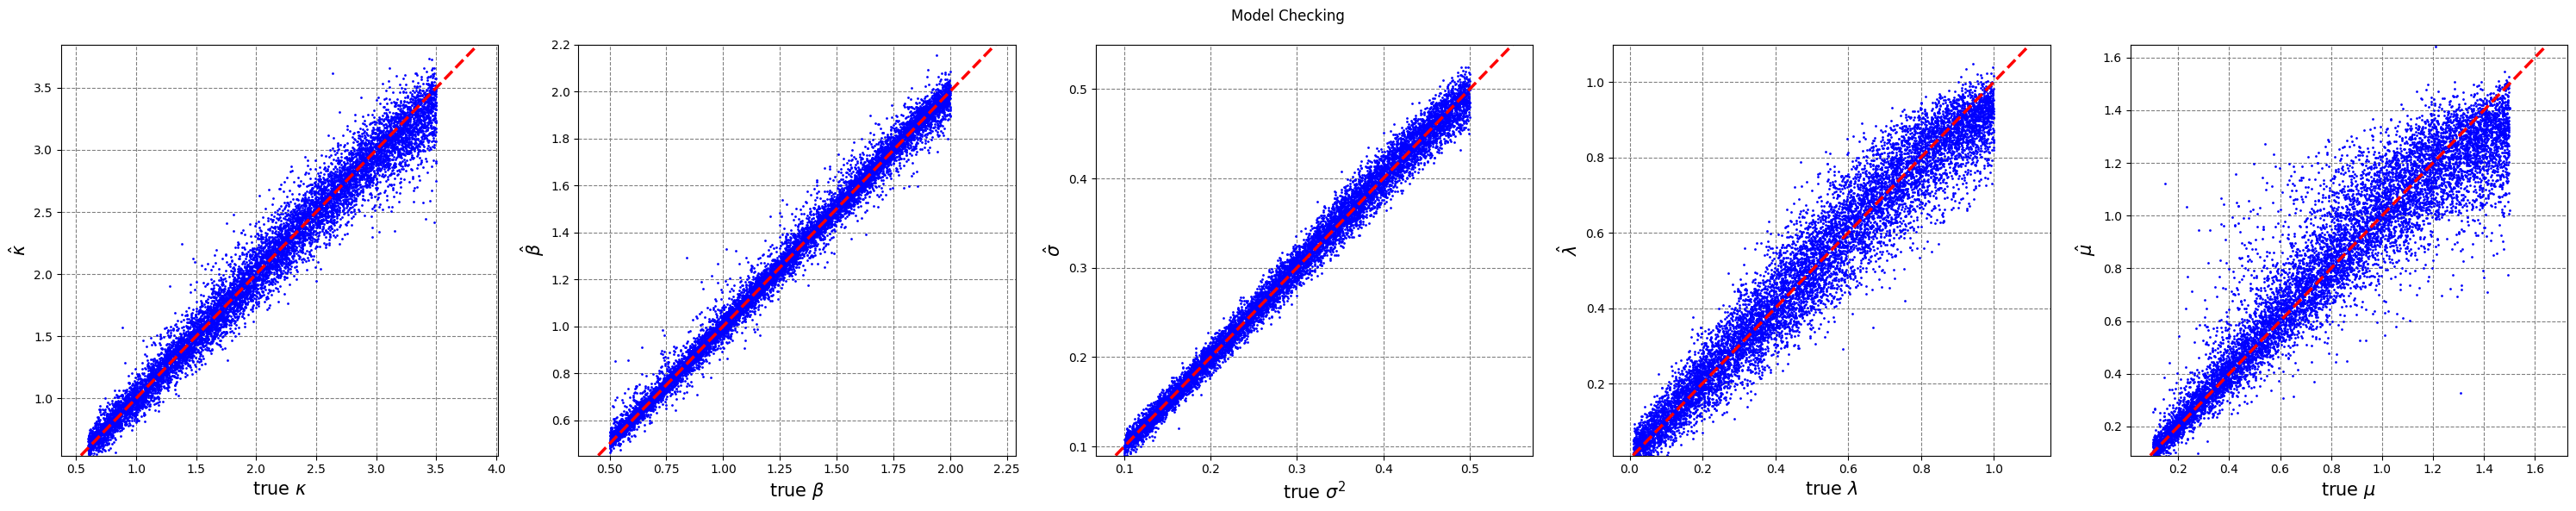

In [17]:
print(min(val_error_plt))
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']
#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']
#esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp1 = net(X_test)[:,0]
    tmp2 = net(X_test)[:,1]
    tmp3 = net(X_test)[:,2]
    tmp4 = net(X_test)[:,3]
    tmp5 = net(X_test)[:,4]

tmp = [tmp1.detach().cpu().numpy().tolist(),
       tmp2.detach().cpu().numpy().tolist(),
       tmp3.detach().cpu().numpy().tolist(),
       tmp4.detach().cpu().numpy().tolist(),
       tmp5.detach().cpu().numpy().tolist()]


## Plot for model checking
lim = [[kappa_range[0] * 0.9, kappa_range[1] * 1.1]
       ,[beta_range[0] * 0.9, beta_range[1] * 1.1]
       ,[sigma2_range[0] * 0.9, sigma2_range[1] * 1.1]
       ,[lambda_range[0] * 0.9, lambda_range[1] * 1.1]
       ,[mu_range[0] * 0.9, mu_range[1] * 1.1]]
#lim = [[kappa_range[0] * 0.8, kappa_range[1] * 1.1]
#       ,[beta_range[0] * 1.1, beta_range[1] * 1.1]
#       ,[lambda_range[0] * 0.8, lambda_range[1] * 1.1]
#       ,[mu_range[0] * 1.1, mu_range[1] * 1.1]]

fig, axes = plt.subplots(1, len(tmp), figsize=(30,6))
fig.suptitle('Model Checking')

for i in range(len(tmp)):
    lim1 = lim[i]
    tmp1 = tmp[i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim(lim1)

fig.tight_layout()
#fig.savefig("SQRJ_plots/SQRJ_baslines.pdf") 

In [ ]:
tmp = [torch.min(output,0).values.detach().cpu().numpy(),
torch.max(output,0).values.detach().cpu().numpy()]
tmp2 = tmp[1] - tmp[0]
tmp = [tmp[0] - tmp2 * 1/20, tmp[1] + tmp2 * 1/20 ]
print(tmp)

In [ ]:
print(lim)

In [ ]:
plt.plot(range(N_EPOCHS), np.log(val_error_plt))
plt.plot(range(N_EPOCHS), np.log(train_error_plt))
torch.save([val_error_plt, train_error_plt], "SQRJ_plots/SQRJ_error_plt_baselines.pt")